# 🧠 Predicción de Nivel de Estrés en Estudiantes Universitarios

**Dataset:** Student Stress Factors (1100 encuestas, estudiantes 18–21 años)  
**Target:** `stress_level` — `0` Sin Estrés · `1` Euestrés · `2` Distrés  
**Features:** 20 variables agrupadas en 5 dominios (psicológico, fisiológico, ambiental, académico, social)  
**Propósito:** Clasificación multiclase — comparación de 3 modelos con GridSearchCV · métrica principal F1-macro

---
## 1. Configuración y carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (f1_score, accuracy_score, classification_report,
                              confusion_matrix, ConfusionMatrixDisplay)

plt.rcParams['figure.dpi'] = 110
sns.set_theme(style='whitegrid', palette='muted')

RANDOM_STATE = 42

# Grupos de features
PSYCHOLOGICAL  = ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression']
PHYSIOLOGICAL  = ['headache', 'blood_pressure', 'sleep_quality', 'breathing_problem']
ENVIRONMENTAL  = ['noise_level', 'living_conditions', 'safety', 'basic_needs']
ACADEMIC       = ['academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns']
SOCIAL         = ['social_support', 'peer_pressure', 'extracurricular_activities', 'bullying']
FEATURE_COLS   = PSYCHOLOGICAL + PHYSIOLOGICAL + ENVIRONMENTAL + ACADEMIC + SOCIAL
TARGET_COL     = 'stress_level'

CLASS_NAMES   = {0: 'Sin Estres', 1: 'Euestres', 2: 'Distres'}
CLASS_COLORS  = {0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'}
GROUP_COLORS  = {
    'Psicologico': '#9b59b6',
    'Fisiologico': '#e74c3c',
    'Ambiental'  : '#2ecc71',
    'Academico'  : '#3498db',
    'Social'     : '#f39c12',
}

def feature_group(f):
    if f in PSYCHOLOGICAL: return 'Psicologico'
    if f in PHYSIOLOGICAL: return 'Fisiologico'
    if f in ENVIRONMENTAL: return 'Ambiental'
    if f in ACADEMIC:      return 'Academico'
    return 'Social'

In [2]:
df = pd.read_csv('StressLevelDataset.csv')

print(f'Filas x Columnas : {df.shape}')
print(f'Duplicados        : {df.duplicated(subset=FEATURE_COLS).sum()}')
print(f'Valores faltantes : {df.isnull().sum().sum()}')
print(f'Dtype dominante   : {df.dtypes.value_counts().idxmax()}')
print()
display(df.head(4))
display(df.describe().round(2))

Filas x Columnas : (1100, 21)
Duplicados        : 0
Valores faltantes : 0
Dtype dominante   : int64



,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
count,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,...,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00,1100.00
mean,11.06,17.78,0.49,12.56,2.51,2.18,2.66,2.75,2.65,2.52,...,2.77,2.77,2.62,2.65,2.65,1.88,2.73,2.77,2.62,1.00
std,6.12,8.94,0.50,7.73,1.41,0.83,1.55,1.40,1.33,1.12,...,1.43,1.41,1.32,1.38,1.53,1.05,1.43,1.42,1.53,0.82
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,6.00,11.00,0.00,6.00,1.00,1.00,1.00,2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,1.00,1.00,2.00,2.00,1.00,0.00
50%,11.00,19.00,0.00,12.00,3.00,2.00,2.50,3.00,3.00,2.00,...,3.00,2.00,2.00,2.00,2.00,2.00,2.00,2.50,3.00,1.00
75%,16.00,26.00,1.00,19.00,3.00,3.00,4.00,4.00,3.00,3.00,...,4.00,4.00,3.00,4.00,4.00,3.00,4.00,4.00,4.00,2.00
max,21.00,30.00,1.00,27.00,5.00,3.00,5.00,5.00,5.00,5.00,...,5.00,5.00,5.00,5.00,5.00,3.00,5.00,5.00,5.00,2.00


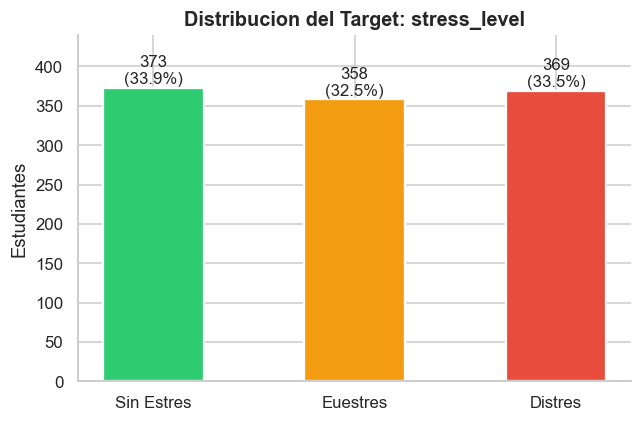

In [3]:
counts = df[TARGET_COL].value_counts().sort_index()
labels = [CLASS_NAMES[i] for i in counts.index]
colors = [CLASS_COLORS[i] for i in counts.index]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, counts.values, color=colors, edgecolor='white', linewidth=1.5, width=0.5)
for bar, v in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, v + 5,
            f'{v}\n({100*v/len(df):.1f}%)', ha='center', fontsize=11)
ax.set_ylim(0, counts.max() * 1.18)
ax.set_ylabel('Estudiantes')
ax.set_title('Distribucion del Target: stress_level', fontsize=13, fontweight='bold')
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.show()

---
## 2. Análisis Exploratorio (EDA)

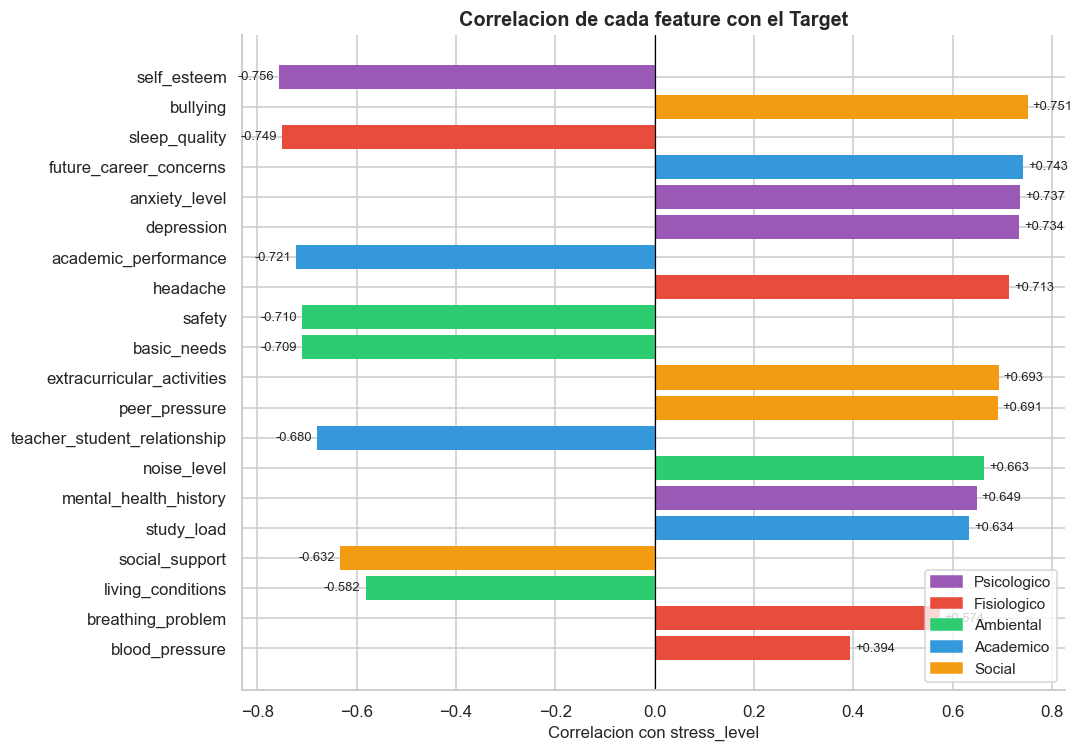

Feature mas correlacionada : self_esteem  (-0.7562)
Feature menos correlacionada: blood_pressure (+0.3942)


In [4]:
corr = df[FEATURE_COLS + [TARGET_COL]].corr()[TARGET_COL].drop(TARGET_COL).sort_values(key=abs, ascending=False)

group_col = [GROUP_COLORS[feature_group(f)] for f in corr.index]

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(corr.index[::-1], corr.values[::-1], color=group_col[::-1], edgecolor='none')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Correlacion con stress_level', fontsize=11)
ax.set_title('Correlacion de cada feature con el Target', fontsize=13, fontweight='bold')
ax.spines[['top','right']].set_visible(False)

legend_handles = [mpatches.Patch(color=c, label=g) for g, c in GROUP_COLORS.items()]
ax.legend(handles=legend_handles, loc='lower right', fontsize=10)

for bar, val in zip(bars[::-1], corr.values):
    ax.text(val + (0.01 if val >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
            f'{val:+.3f}', va='center', ha='left' if val >= 0 else 'right', fontsize=8.5)

plt.tight_layout()
plt.show()

print(f'Feature mas correlacionada : {corr.index[0]}  ({corr.iloc[0]:+.4f})')
print(f'Feature menos correlacionada: {corr.index[-1]} ({corr.iloc[-1]:+.4f})')

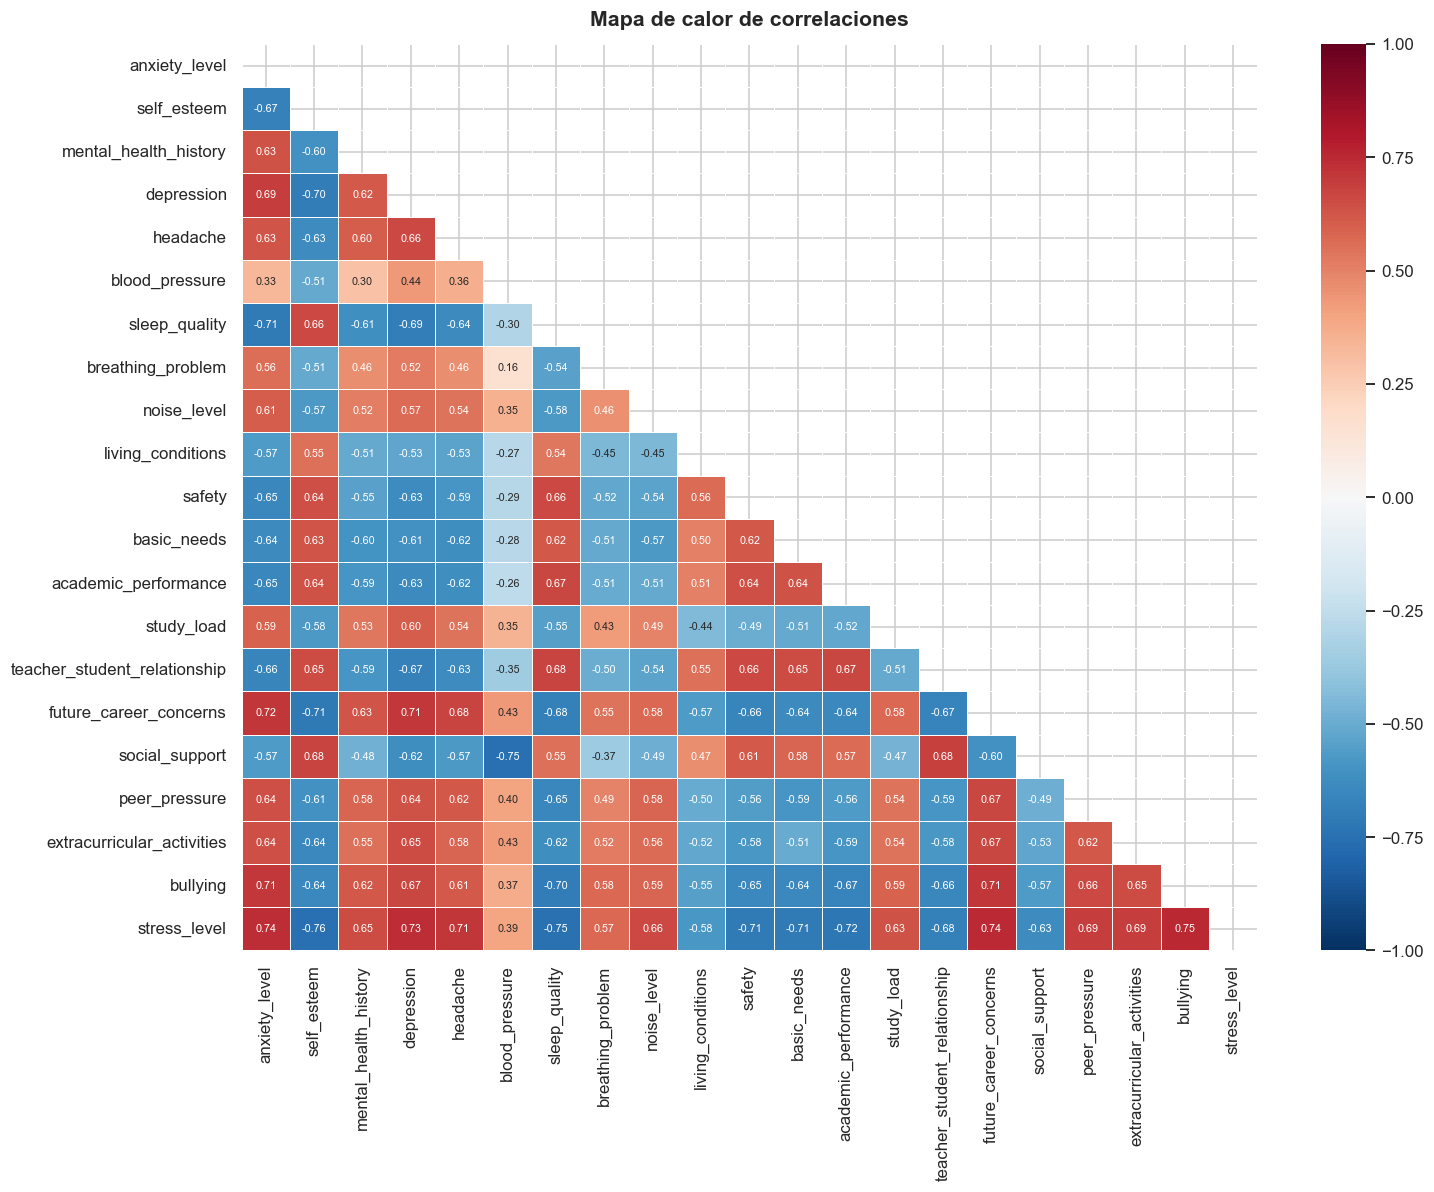

In [5]:
corr_matrix = df[FEATURE_COLS + [TARGET_COL]].corr()

fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, linewidths=0.4, linecolor='white',
            annot=True, fmt='.2f', annot_kws={'size': 7},
            ax=ax)
ax.set_title('Mapa de calor de correlaciones', fontsize=14, fontweight='bold', pad=12)
plt.tight_layout()
plt.show()

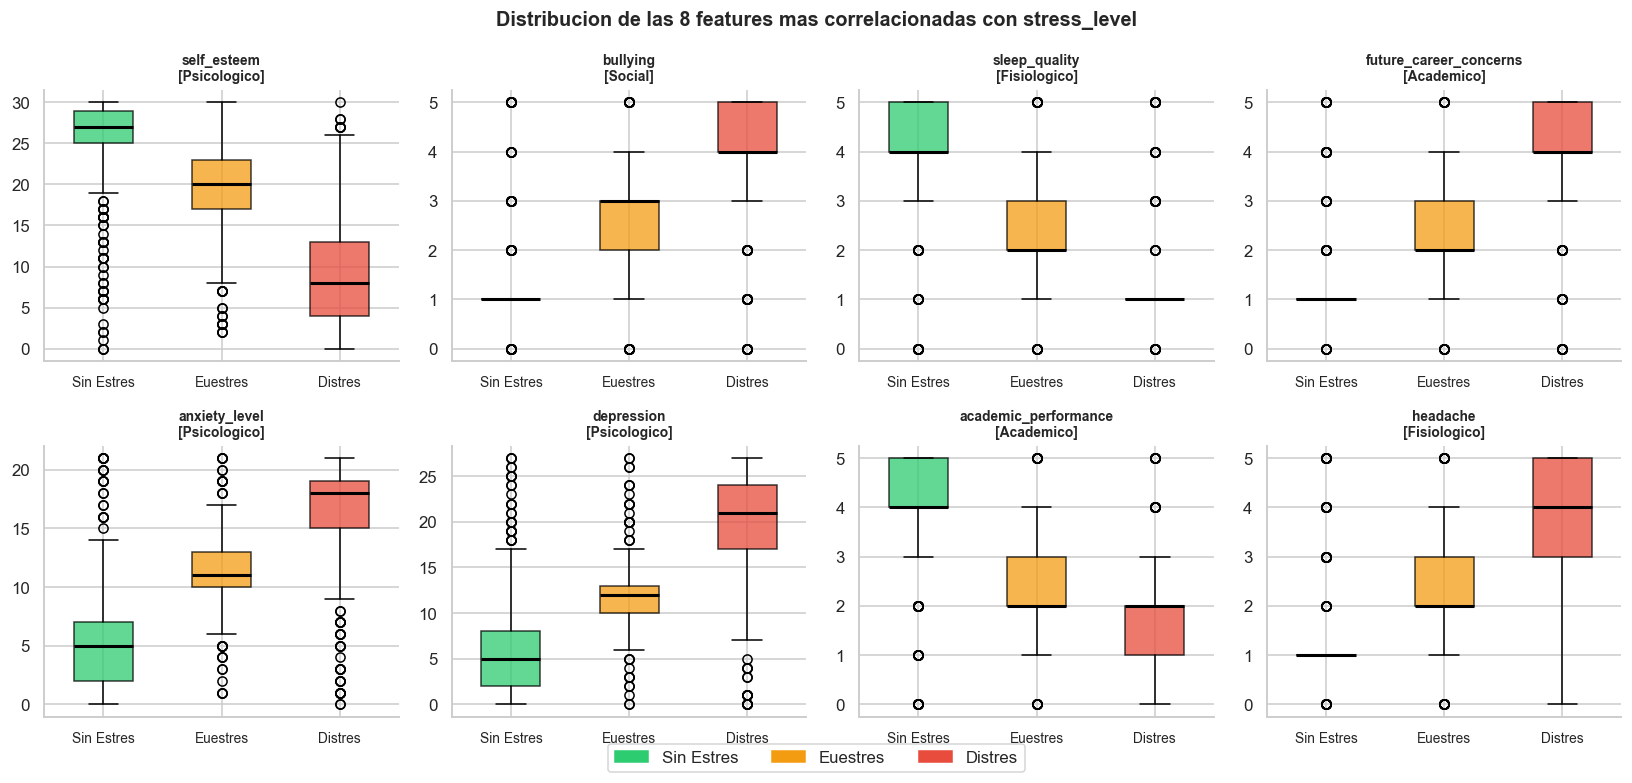

In [6]:
# Top 8 features por correlacion absoluta con el target
top8 = corr.abs().nlargest(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flatten()

stress_labels = [CLASS_NAMES[i] for i in sorted(CLASS_NAMES.keys())]
palette = {i: CLASS_COLORS[i] for i in CLASS_COLORS}

for ax, feat in zip(axes, top8):
    data_plot = [df[df[TARGET_COL] == cls][feat].values for cls in sorted(CLASS_NAMES.keys())]
    bp = ax.boxplot(data_plot, patch_artist=True, notch=False, widths=0.5,
                    medianprops=dict(color='black', linewidth=2))
    for patch, cls in zip(bp['boxes'], sorted(CLASS_NAMES.keys())):
        patch.set_facecolor(CLASS_COLORS[cls])
        patch.set_alpha(0.75)
    ax.set_xticklabels(stress_labels, fontsize=9)
    grp = feature_group(feat)
    ax.set_title(f'{feat}\n[{grp}]', fontsize=9, fontweight='bold')
    ax.spines[['top','right']].set_visible(False)

legend_handles = [mpatches.Patch(color=CLASS_COLORS[i], label=CLASS_NAMES[i]) for i in sorted(CLASS_NAMES.keys())]
fig.legend(handles=legend_handles, loc='lower center', ncol=3, fontsize=11, frameon=True, bbox_to_anchor=(0.5, -0.02))
plt.suptitle('Distribucion de las 8 features mas correlacionadas con stress_level',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

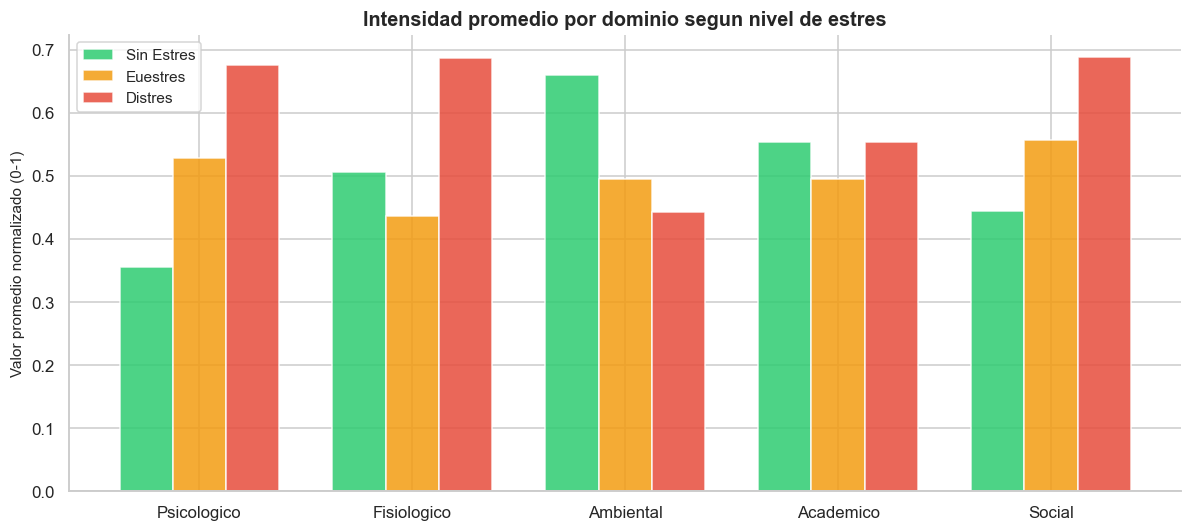

In [7]:
# Media por grupo de features segun nivel de estres
group_map = {}
for f in FEATURE_COLS:
    group_map[f] = feature_group(f)

df_melt = df[FEATURE_COLS + [TARGET_COL]].melt(id_vars=TARGET_COL, var_name='feature', value_name='value')
df_melt['grupo'] = df_melt['feature'].map(group_map)
df_melt['stress_label'] = df_melt[TARGET_COL].map(CLASS_NAMES)

# Normalizar values a 0-1 por feature para comparar escalas distintas
for feat in FEATURE_COLS:
    mn = df[feat].min(); mx = df[feat].max()
    if mx > mn:
        df_melt.loc[df_melt['feature'] == feat, 'value_norm'] = (df_melt.loc[df_melt['feature'] == feat, 'value'] - mn) / (mx - mn)
    else:
        df_melt.loc[df_melt['feature'] == feat, 'value_norm'] = 0.0

group_mean = (df_melt.groupby(['grupo', 'stress_label'])['value_norm']
              .mean().reset_index())
group_mean['stress_order'] = group_mean['stress_label'].map({'Sin Estres': 0, 'Euestres': 1, 'Distres': 2})
group_mean = group_mean.sort_values('stress_order')

fig, ax = plt.subplots(figsize=(11, 5))
grupos = list(GROUP_COLORS.keys())
x = np.arange(len(grupos))
width = 0.25

for i, (cls, lbl) in enumerate(CLASS_NAMES.items()):
    vals = [group_mean[(group_mean['grupo'] == g) & (group_mean['stress_label'] == lbl)]['value_norm'].values
            for g in grupos]
    vals = [v[0] if len(v) > 0 else 0 for v in vals]
    ax.bar(x + i*width, vals, width, label=lbl, color=CLASS_COLORS[cls], alpha=0.85, edgecolor='white')

ax.set_xticks(x + width)
ax.set_xticklabels(grupos, fontsize=11)
ax.set_ylabel('Valor promedio normalizado (0-1)', fontsize=10)
ax.set_title('Intensidad promedio por dominio segun nivel de estres', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.show()

---
## 3. Preprocesamiento

In [8]:
X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f'Features    : {len(FEATURE_COLS)} variables numericas (escala Likert)')
print(f'Train set   : {len(X_train)} muestras  ({100*len(X_train)/len(df):.0f}%)')
print(f'Test set    : {len(X_test)} muestras   ({100*len(X_test)/len(df):.0f}%)')
print()
print('Distribucion de clases (train vs test):')
for cls in sorted(y.unique()):
    n_tr = (y_train == cls).sum()
    n_te = (y_test  == cls).sum()
    print(f'  {CLASS_NAMES[cls]:<12} -> Train: {n_tr} ({100*n_tr/len(y_train):.1f}%)  |  Test: {n_te} ({100*n_te/len(y_test):.1f}%)')

print()
print('Pipeline: StandardScaler -> Clasificador')
print('  - StandardScaler es necesario para Logistic Regression (features en distintas escalas)')
print('  - Se aplica igual a RF y GB para uniformidad del pipeline')

Features    : 20 variables numericas (escala Likert)
Train set   : 880 muestras  (80%)
Test set    : 220 muestras   (20%)

Distribucion de clases (train vs test):
  Sin Estres   -> Train: 299 (34.0%)  |  Test: 74 (33.6%)
  Euestres     -> Train: 286 (32.5%)  |  Test: 72 (32.7%)
  Distres      -> Train: 295 (33.5%)  |  Test: 74 (33.6%)

Pipeline: StandardScaler -> Clasificador
  - StandardScaler es necesario para Logistic Regression (features en distintas escalas)
  - Se aplica igual a RF y GB para uniformidad del pipeline


---
## 4. Entrenamiento y selección de modelo

Se comparan 3 algoritmos con búsqueda de hiperparámetros por **GridSearchCV (5-fold, F1-macro)**.

In [9]:
models_config = {
    'Logistic Regression': {
        'estimator': LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
        'params': {
            'classifier__C':      [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['lbfgs', 'saga'],
        }
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'classifier__n_estimators':   [100, 200],
            'classifier__max_depth':      [None, 10, 20],
            'classifier__min_samples_leaf': [1, 2, 4],
        }
    },
    'Gradient Boosting': {
        'estimator': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'params': {
            'classifier__n_estimators':  [100, 200],
            'classifier__learning_rate': [0.05, 0.1, 0.2],
            'classifier__max_depth':     [3, 5],
        }
    },
}

results = {}

for name, config in models_config.items():
    pipe = Pipeline([
        ('scaler',     StandardScaler()),
        ('classifier', config['estimator']),
    ])
    gs = GridSearchCV(
        pipe, config['params'],
        cv=5, scoring='f1_macro',
        n_jobs=-1, verbose=1
    )
    t0 = time.time()
    gs.fit(X_train, y_train)
    elapsed = time.time() - t0

    results[name] = {
        'cv_f1':      gs.best_score_,
        'best_params': gs.best_params_,
        'pipeline':   gs.best_estimator_,
        'time_s':     elapsed,
    }
    print(f'  [{name}]  CV F1={gs.best_score_:.4f}  t={elapsed:.1f}s')
    print(f'    Mejores params: {gs.best_params_}\n')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
  [Logistic Regression]  CV F1=0.8810  t=6.2s
    Mejores params: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
  [Random Forest]  CV F1=0.8757  t=3.1s
    Mejores params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 200}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
  [Gradient Boosting]  CV F1=0.8931  t=7.0s
    Mejores params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}



In [10]:
cv_rows = [
    {'Modelo': name, 'F1-macro CV (5-fold)': round(res['cv_f1'], 4),
     'Tiempo (s)': round(res['time_s'], 1), 'Mejores hiperparametros': res['best_params']}
    for name, res in results.items()
]
df_cv = pd.DataFrame(cv_rows).sort_values('F1-macro CV (5-fold)', ascending=False).reset_index(drop=True)
print('=== Resultados de GridSearchCV ===')
display(df_cv)

=== Resultados de GridSearchCV ===


,Modelo,F1-macro CV (5-fold),Tiempo (s),Mejores hiperparametros
0,Gradient Boosting,0.8931,7.0,"{'classifier__learning_rate': 0.2, 'classifier..."
1,Logistic Regression,0.8810,6.2,"{'classifier__C': 0.1, 'classifier__solver': '..."
2,Random Forest,0.8757,3.1,"{'classifier__max_depth': None, 'classifier__m..."


---
## 5. Evaluación en Train y Test

In [11]:
eval_rows = []
for name, res in results.items():
    pipe = res['pipeline']
    f1_tr  = f1_score(y_train, pipe.predict(X_train), average='macro')
    f1_te  = f1_score(y_test,  pipe.predict(X_test),  average='macro')
    acc_tr = accuracy_score(y_train, pipe.predict(X_train))
    acc_te = accuracy_score(y_test,  pipe.predict(X_test))
    eval_rows.append({
        'Modelo':           name,
        'F1-macro Train':   round(f1_tr, 4),
        'F1-macro Test':    round(f1_te, 4),
        'Gap (Train-Test)': round(f1_tr - f1_te, 4),
        'Accuracy Train':   round(acc_tr, 4),
        'Accuracy Test':    round(acc_te, 4),
    })

df_eval = pd.DataFrame(eval_rows).sort_values('F1-macro Test', ascending=False).reset_index(drop=True)
print('=== Comparacion Train vs Test ===')
display(df_eval)

print()
print('Interpretacion del Gap (Train - Test):')
for _, row in df_eval.iterrows():
    gap = row['Gap (Train-Test)']
    if gap < 0.03:
        tag = 'Generalizacion buena'
    elif gap < 0.06:
        tag = 'Overfitting leve'
    else:
        tag = 'Overfitting moderado'
    print(f'  {row["Modelo"]:<25} gap={gap:.4f}  -> {tag}')

=== Comparacion Train vs Test ===


,Modelo,F1-macro Train,F1-macro Test,Gap (Train-Test),Accuracy Train,Accuracy Test
0,Logistic Regression,0.9025,0.8868,0.0158,0.9023,0.8864
1,Random Forest,0.9966,0.8773,0.1193,0.9966,0.8773
2,Gradient Boosting,1.0000,0.8725,0.1275,1.0000,0.8727



Interpretacion del Gap (Train - Test):
  Logistic Regression       gap=0.0158  -> Generalizacion buena
  Random Forest             gap=0.1193  -> Overfitting moderado
  Gradient Boosting         gap=0.1275  -> Overfitting moderado


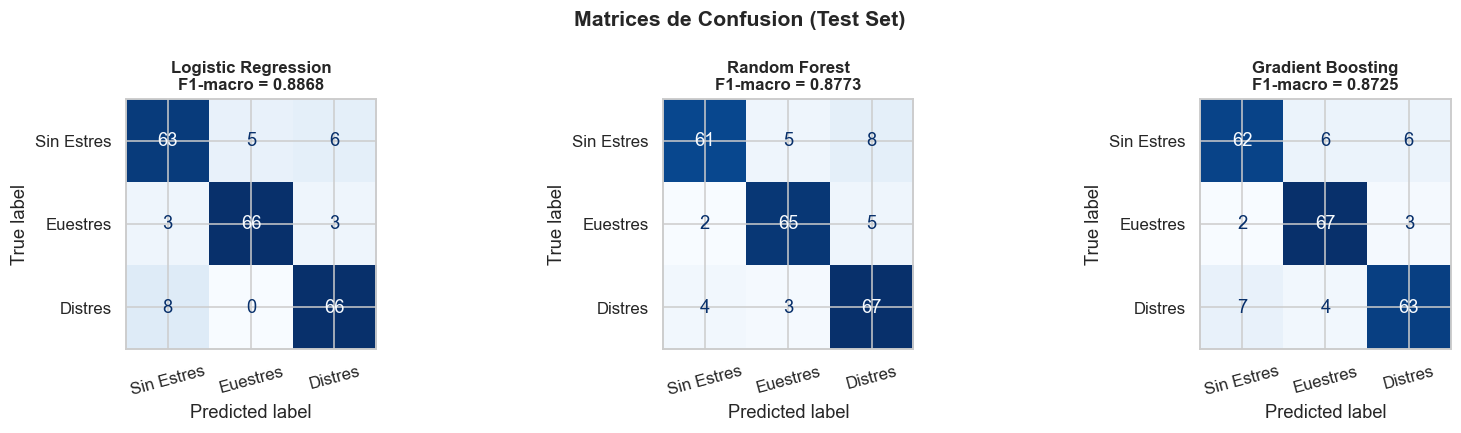

In [12]:
class_labels = [CLASS_NAMES[i] for i in sorted(CLASS_NAMES.keys())]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, res) in zip(axes, results.items()):
    pipe = res['pipeline']
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    f1 = f1_score(y_test, y_pred, average='macro')
    ax.set_title(f'{name}\nF1-macro = {f1:.4f}', fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', labelrotation=15)

plt.suptitle('Matrices de Confusion (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
# Reporte detallado del mejor modelo segun F1-macro en test
best_name = df_eval.iloc[0]['Modelo']
best_pipe = results[best_name]['pipeline']
y_pred_best = best_pipe.predict(X_test)

print(f'=== Reporte detallado: {best_name} ===')
print(classification_report(y_test, y_pred_best, target_names=class_labels))

=== Reporte detallado: Logistic Regression ===
              precision    recall  f1-score   support

  Sin Estres       0.85      0.85      0.85        74
    Euestres       0.93      0.92      0.92        72
     Distres       0.88      0.89      0.89        74

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220



---
## 6. Importancia de Features

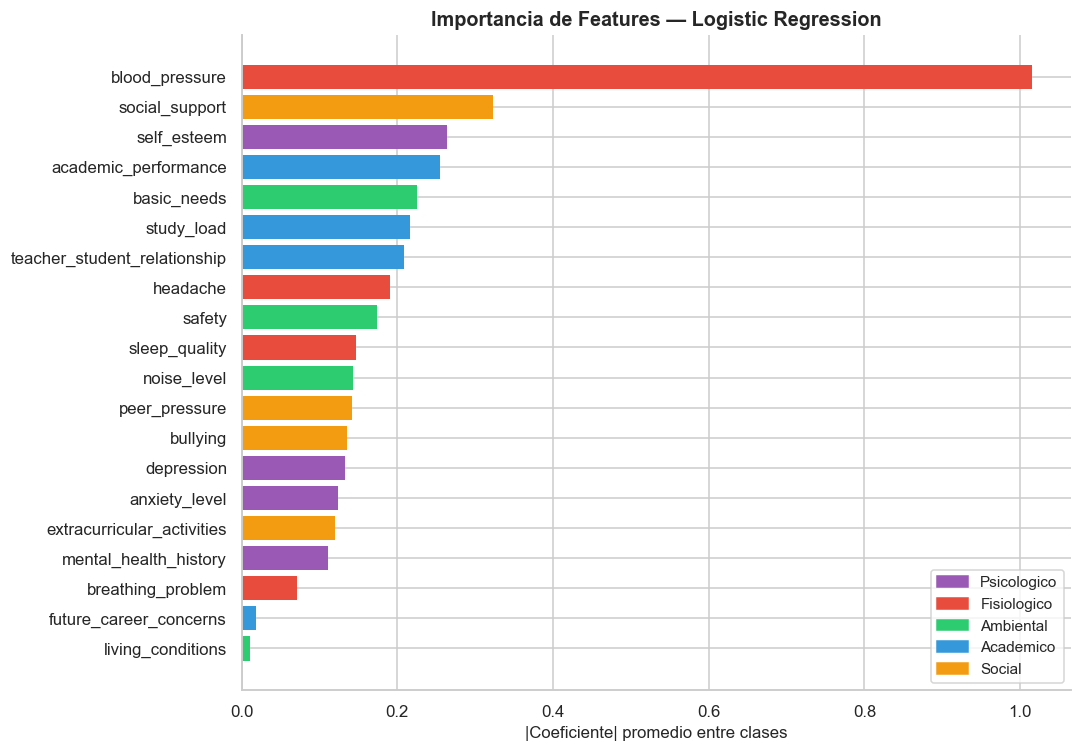

Top 5 features mas importantes:
  blood_pressure                 1.0150  [Fisiologico]
  social_support                 0.3232  [Social]
  self_esteem                    0.2639  [Psicologico]
  academic_performance           0.2549  [Academico]
  basic_needs                    0.2256  [Ambiental]


In [14]:
clf = best_pipe.named_steps['classifier']

if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    imp_label = 'Importancia (Gini)'
elif hasattr(clf, 'coef_'):
    importances = np.abs(clf.coef_).mean(axis=0)
    imp_label = '|Coeficiente| promedio entre clases'

idx = np.argsort(importances)[::-1]
sorted_feats = [FEATURE_COLS[i] for i in idx]
sorted_imps  = importances[idx]
feat_colors  = [GROUP_COLORS[feature_group(f)] for f in sorted_feats]

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(sorted_feats[::-1], sorted_imps[::-1], color=feat_colors[::-1], edgecolor='none')
ax.set_xlabel(imp_label, fontsize=11)
ax.set_title(f'Importancia de Features — {best_name}', fontsize=13, fontweight='bold')
ax.spines[['top','right']].set_visible(False)

legend_handles = [mpatches.Patch(color=c, label=g) for g, c in GROUP_COLORS.items()]
ax.legend(handles=legend_handles, loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

print(f'Top 5 features mas importantes:')
for f, v in zip(sorted_feats[:5], sorted_imps[:5]):
    print(f'  {f:<30} {v:.4f}  [{feature_group(f)}]')

---
## 7. Guardado del Modelo

In [15]:
import os

MODEL_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'stress_model.joblib')
joblib.dump(best_pipe, MODEL_PATH)

print(f'Modelo guardado')
print(f'Algoritmo       : {best_name}')
print(f'F1-macro Test   : {df_eval.iloc[0]["F1-macro Test"]:.4f}')
print(f'Accuracy Test   : {df_eval.iloc[0]["Accuracy Test"]:.4f}')

# Verificacion: recargar y predecir una muestra
loaded_model = joblib.load(MODEL_PATH)
sample = X_test.iloc[:3].copy()
preds = loaded_model.predict(sample)
probas = loaded_model.predict_proba(sample)
print()
print('Verificacion de carga del modelo (3 muestras):')
for i, (pred, proba) in enumerate(zip(preds, probas)):
    real = y_test.iloc[i]
    print(f'  Muestra {i+1}: Real={CLASS_NAMES[real]}  Predicho={CLASS_NAMES[pred]}  Prob={[f"{p:.2f}" for p in proba]}')

Modelo guardado
Algoritmo       : Logistic Regression
F1-macro Test   : 0.8868
Accuracy Test   : 0.8864

Verificacion de carga del modelo (3 muestras):
  Muestra 1: Real=Sin Estres  Predicho=Sin Estres  Prob=['0.97', '0.03', '0.00']
  Muestra 2: Real=Sin Estres  Predicho=Sin Estres  Prob=['0.98', '0.02', '0.00']
  Muestra 3: Real=Distres  Predicho=Distres  Prob=['0.00', '0.03', '0.97']
